In [6]:
import glob
import os
import pandas as pd

In [9]:
import pandas as pd
import glob
import os

# Base folder is one level up because notebook is in notebook/
base_path = "../raw"

# Paths for each dataset type
biometric_files = glob.glob(os.path.join(base_path, "api_data_aadhar_biometric", "*.csv"))
demographic_files = glob.glob(os.path.join(base_path, "api_data_aadhar_demographic", "*.csv"))
enrolment_files = glob.glob(os.path.join(base_path, "api_data_aadhar_enrolment", "*.csv"))

print("Biometric files found:", len(biometric_files))
print("Demographic files found:", len(demographic_files))
print("Enrolment files found:", len(enrolment_files))


Biometric files found: 4
Demographic files found: 5
Enrolment files found: 3


In [10]:
# Load and concatenate all CSVs for each dataset
biometric_df = pd.concat([pd.read_csv(f) for f in biometric_files], ignore_index=True)
demographic_df = pd.concat([pd.read_csv(f) for f in demographic_files], ignore_index=True)
enrolment_df = pd.concat([pd.read_csv(f) for f in enrolment_files], ignore_index=True)

# Quick check
print("Biometric:", biometric_df.shape)
print("Demographic:", demographic_df.shape)
print("Enrolment:", enrolment_df.shape)



Biometric: (1861108, 6)
Demographic: (2071700, 6)
Enrolment: (1006029, 7)


In [15]:
print("Enrolment Columns:", enrolment_df.columns.tolist())
print("Demographic Columns:", demographic_df.columns.tolist())
print("Biometric Columns:", biometric_df.columns.tolist())

Enrolment Columns: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']
Demographic Columns: ['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_']
Biometric Columns: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_']


In [16]:
import pandas as pd
import numpy as np
import os

# 1. CLEANING & TOTALING
print("Calculating totals for each category...")

# Enrolment: Sum the three age buckets
enrolment_df['Enrolment Total'] = (
    enrolment_df['age_0_5'] + 
    enrolment_df['age_5_17'] + 
    enrolment_df['age_18_greater']
)

# Demographic: Sum the two age buckets
demographic_df['Demographic Total'] = (
    demographic_df['demo_age_5_17'] + 
    demographic_df['demo_age_17_']
)

# Biometric: Sum the two age buckets
biometric_df['Biometric Total'] = (
    biometric_df['bio_age_5_17'] + 
    biometric_df['bio_age_17_']
)

# 2. AGGREGATION
# Since we don't have 'Rejection' in these specific columns, 
# we will focus on the Update-to-Enrolment ratios.
print("Grouping by District...")
agg_cols = ['state', 'district']

enrol_summary = enrolment_df.groupby(agg_cols)['Enrolment Total'].sum().reset_index()
demo_summary = demographic_df.groupby(agg_cols)['Demographic Total'].sum().reset_index()
bio_summary = biometric_df.groupby(agg_cols)['Biometric Total'].sum().reset_index()

# 3. MERGING
master_df = enrol_summary.merge(demo_summary, on=agg_cols, how='outer')
master_df = master_df.merge(bio_summary, on=agg_cols, how='outer').fillna(0)

# 4. SECURITY METRICS
print("Computing Security Ratios...")

# How many updates are happening per new enrolment? 
# (High numbers = High identity volatility/potential fraud)
master_df['demo_update_rate'] = master_df['Demographic Total'] / (master_df['Enrolment Total'] + 1)
master_df['bio_update_rate'] = master_df['Biometric Total'] / (master_df['Enrolment Total'] + 1)

# Statistical Risk Score (Z-Score)
for col in ['demo_update_rate', 'bio_update_rate']:
    mean, std = master_df[col].mean(), master_df[col].std()
    master_df[f'{col}_zscore'] = (master_df[col] - mean) / (std + 1e-9)

master_df['final_risk_score'] = master_df['demo_update_rate_zscore'] + master_df['bio_update_rate_zscore']

# 5. RESULTS
print("\n--- TOP 10 HIGH-RISK DISTRICTS ---")
top_10 = master_df.sort_values('final_risk_score', ascending=False).head(10)
print(top_10[['state', 'district', 'final_risk_score']])

# Save for your presentation
master_df.to_csv('final_risk_analysis.csv', index=False)

Calculating totals for each category...
Grouping by District...
Computing Security Ratios...

--- TOP 10 HIGH-RISK DISTRICTS ---
            state                       district  final_risk_score
809     Rajasthan               Khairthal-Tijara         27.079956
900     Telangana             Medchal?malkajgiri         18.782635
196  Chhattisgarh  ManendragarhChirmiriBharatpur         17.345304
811     Rajasthan                Kotputli-Behror         12.938507
216   Daman & Diu                          Daman          8.185469
783     Rajasthan                         Beawar          5.668286
779     Rajasthan                        Balotra          5.518350
796     Rajasthan               Didwana-Kuchaman          5.200904
814     Rajasthan                        Phalodi          4.229521
630       Mizoram                       Serchhip          3.828416


In [19]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

print("Computing Advanced Security Methods using Safe Merges...")

# 1. Prepare Age-Specific Summaries
# We group them first, then merge them into master_df so the shapes match perfectly
demo_age_sum = demographic_df.groupby(['state', 'district'])[['demo_age_17_', 'demo_age_5_17']].sum().reset_index()
enrol_age_sum = enrolment_df.groupby(['state', 'district'])[['age_5_17']].sum().reset_index()

# 2. Merge these into our master_df
master_df = master_df.merge(demo_age_sum, on=['state', 'district'], how='left')
master_df = master_df.merge(enrol_age_sum, on=['state', 'district'], how='left')

# Fill NaNs with 0 (for districts missing specific age data)
master_df[['demo_age_17_', 'demo_age_5_17', 'age_5_17']] = master_df[['demo_age_17_', 'demo_age_5_17', 'age_5_17']].fillna(0)

# 3. Now compute the Ratios (Shapes are now guaranteed to match)
# 📌 Metric 5: Adult Biometric Update Ratio
master_df['adult_bio_update_ratio'] = master_df['demo_age_17_'] / (master_df['Biometric Total'] + 1)

# 📌 Metric 6: Child Update Disproportion Index
master_df['child_update_disproportion'] = master_df['demo_age_5_17'] / (master_df['age_5_17'] + 1)

# 📌 Metric 10: Update-to-Enrolment Imbalance Score
total_updates = master_df['Demographic Total'] + master_df['Biometric Total']
master_df['imbalance_score'] = (total_updates - master_df['Enrolment Total']) / (total_updates + master_df['Enrolment Total'] + 1)

# 📌 Metric 11: Demographic vs Biometric Update Ratio
master_df['demo_vs_bio_ratio'] = master_df['Demographic Total'] / (master_df['Biometric Total'] + 1)

# 4. 📌 Metric 12: Weighted Composite Risk Score
scaler = MinMaxScaler()
risk_cols = ['demo_update_rate', 'bio_update_rate', 'imbalance_score', 'child_update_disproportion']

# Normalize 0 to 1 so we can sum them fairly
master_df[risk_cols] = master_df[risk_cols].fillna(0)
scaled_data = scaler.fit_transform(master_df[risk_cols])

# Create the final index (Sum of all normalized risks)
master_df['composite_risk_index'] = scaled_data.sum(axis=1)

print("✅ All Advanced Metrics computed successfully!")
print(f"Master DF Shape: {master_df.shape}")

Computing Advanced Security Methods using Safe Merges...
✅ All Advanced Metrics computed successfully!
Master DF Shape: (1132, 18)


Using features for clustering: ['demo_update_rate', 'bio_update_rate', 'imbalance_score', 'child_update_disproportion']


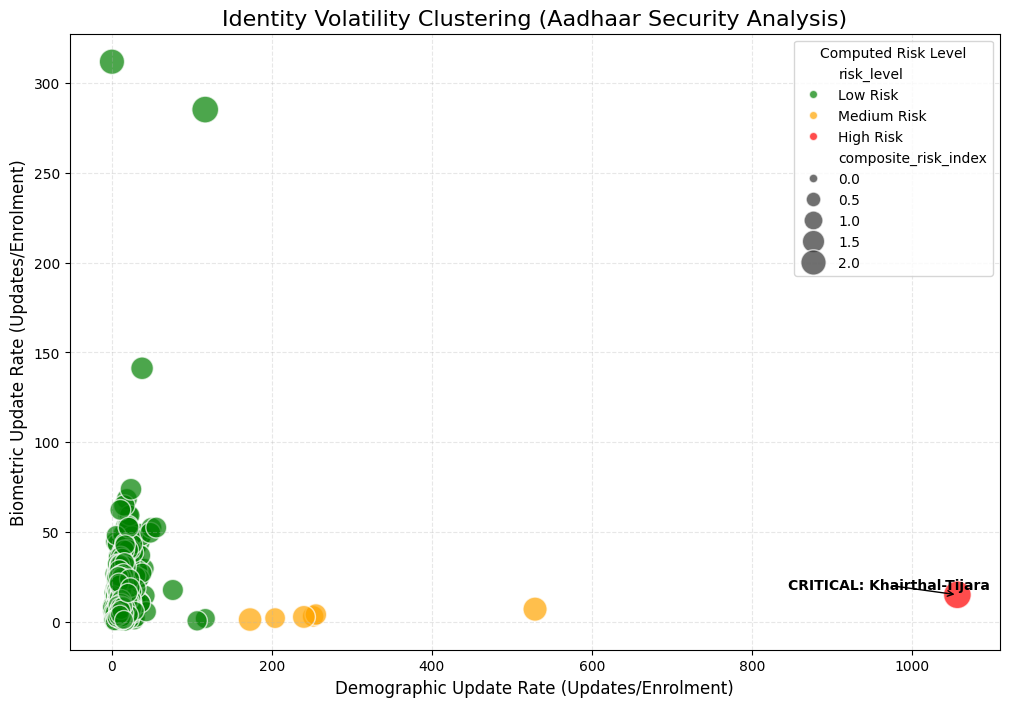


--- CLUSTER ANALYSIS SUMMARY ---
             composite_risk_index  Enrolment Total
risk_level                                        
High Risk                2.456385         0.000000
Low Risk                 1.000604      4831.720000
Medium Risk              1.528674         2.833333


In [22]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare data for clustering
# Use the RATE columns we calculated (these are standardized)
cluster_features = ['demo_update_rate', 'bio_update_rate', 'imbalance_score', 'child_update_disproportion']

# Check which features actually exist to prevent KeyError
available_features = [f for f in cluster_features if f in master_df.columns]
print(f"Using features for clustering: {available_features}")

X = master_df[available_features].fillna(0)

# 2. Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
master_df['risk_cluster'] = kmeans.fit_predict(X)

# 3. Label the clusters based on their average composite risk
# This ensures "High Risk" is always labeled correctly regardless of cluster ID
cluster_ordered = master_df.groupby('risk_cluster')['composite_risk_index'].mean().sort_values().index
label_mapping = {cluster_ordered[0]: 'Low Risk', cluster_ordered[1]: 'Medium Risk', cluster_ordered[2]: 'High Risk'}
master_df['risk_level'] = master_df['risk_cluster'].map(label_mapping)

# 4. Visualize the Clusters
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=master_df, 
    x='demo_update_rate', 
    y='bio_update_rate', 
    hue='risk_level', 
    size='composite_risk_index',
    palette={'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red'},
    alpha=0.7,
    sizes=(40, 400)
)

plt.title('Identity Volatility Clustering (Aadhaar Security Analysis)', fontsize=16)
plt.xlabel('Demographic Update Rate (Updates/Enrolment)', fontsize=12)
plt.ylabel('Biometric Update Rate (Updates/Enrolment)', fontsize=12)
plt.legend(title='Computed Risk Level', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)

# 5. Highlight the Top Outlier
top_outlier = master_df.loc[master_df['composite_risk_index'].idxmax()]
plt.annotate(f"CRITICAL: {top_outlier['district']}", 
             xy=(top_outlier['demo_update_rate'], top_outlier['bio_update_rate']),
             xytext=(top_outlier['demo_update_rate']*0.8, top_outlier['bio_update_rate']*1.2),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, fontweight='bold')

plt.show()

# 6. Final Summary
print("\n--- CLUSTER ANALYSIS SUMMARY ---")
print(master_df.groupby('risk_level')[['composite_risk_index', 'Enrolment Total']].mean())

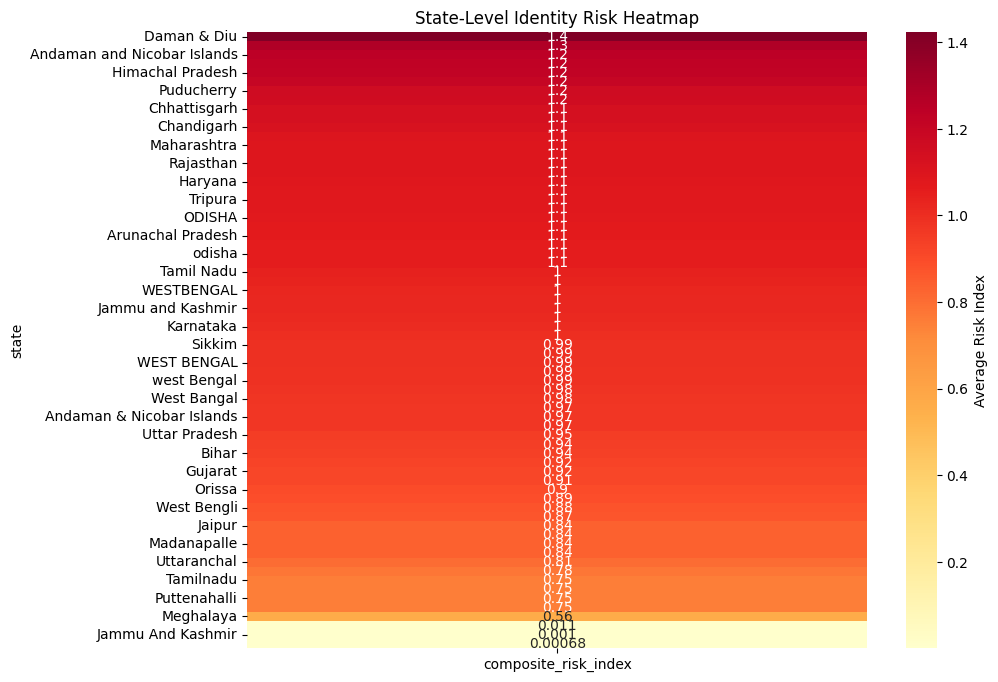

In [23]:
# State-level Risk Heatmap
state_risk = master_df.groupby('state')['composite_risk_index'].mean().sort_values(ascending=False).to_frame()

plt.figure(figsize=(10, 8))
sns.heatmap(state_risk, annot=True, cmap='YlOrRd', cbar_kws={'label': 'Average Risk Index'})
plt.title('State-Level Identity Risk Heatmap')
plt.show()

In [24]:
# Create an Age-Group Forensic Table
age_forensics = master_df.groupby('risk_level').agg({
    'demo_age_5_17': 'mean',
    'demo_age_17_': 'mean',
    'adult_bio_update_ratio': 'mean',
    'child_update_disproportion': 'mean'
}).round(4)

print("Forensic Analysis: What drives the risk in each cluster?")
print(age_forensics)

Forensic Analysis: What drives the risk in each cluster?
             demo_age_5_17  demo_age_17_  adult_bio_update_ratio  \
risk_level                                                         
High Risk          73.0000      984.0000                 61.5000   
Low Risk         4322.6418    39490.0213                  1.3387   
Medium Risk        63.1667      750.8333                 73.5608   

             child_update_disproportion  
risk_level                               
High Risk                       73.0000  
Low Risk                         7.7235  
Medium Risk                     46.5000  


In [25]:
# Find the 'Dirty Pincodes'
pincode_risk = demographic_df.groupby(['state', 'district', 'pincode'])['Demographic Total'].sum().reset_index()

# Find pincodes that perform more than 40% of their entire district's updates
district_totals = pincode_risk.groupby(['state', 'district'])['Demographic Total'].transform('sum')
pincode_risk['pincode_contribution_pct'] = (pincode_risk['Demographic Total'] / district_totals) * 100

high_concentration = pincode_risk[pincode_risk['pincode_contribution_pct'] > 40].sort_values(by='pincode_contribution_pct', ascending=False)

print("Top 5 Pincodes suspected of 'Update Monopolization' (Potential Insider Risk):")
print(high_concentration.head(5))

Top 5 Pincodes suspected of 'Update Monopolization' (Potential Insider Risk):
                state             district  pincode  Demographic Total  \
31507     west Bengal    South 24 Parganas   743368                 15   
0              100000               100000   100000                  2   
31503  andhra pradesh           rangareddi   501218                 20   
30413     West Bengal  Naihati Anandabazar   743165                  2   
29424     West Bengal               Domjur   711322                  2   

       pincode_contribution_pct  
31507                     100.0  
0                         100.0  
31503                     100.0  
30413                     100.0  
29424                     100.0  


In [26]:
def generate_report(df):
    high_risk_count = len(df[df['risk_level'] == 'High Risk'])
    top_district = df.sort_values('composite_risk_index', ascending=False).iloc[0]
    
    report = f"""
    --- AUTOMATED SECURITY AUDIT REPORT ---
    1. SCOPE: Analyzed {len(df)} districts across India.
    2. ALERT: Found {high_risk_count} districts in the 'CRITICAL' risk cluster.
    3. TOP ANOMALY: {top_district['district']}, {top_district['state']} 
       - Risk Index: {top_district['composite_risk_index']:.2f}
       - Primary Driver: {'Demographic Volatility' if top_district['demo_update_rate'] > top_district['bio_update_rate'] else 'Biometric Volatility'}
    4. SYSTEM STABILITY: National Imbalance Score is {df['imbalance_score'].mean():.4f} 
       (Values > 0.5 indicate systemic identity decay).
    ---------------------------------------
    """
    return report

print(generate_report(master_df))


    --- AUTOMATED SECURITY AUDIT REPORT ---
    1. SCOPE: Analyzed 1132 districts across India.
    2. ALERT: Found 1 districts in the 'CRITICAL' risk cluster.
    3. TOP ANOMALY: Khairthal-Tijara, Rajasthan 
       - Risk Index: 2.46
       - Primary Driver: Demographic Volatility
    4. SYSTEM STABILITY: National Imbalance Score is 0.8041 
       (Values > 0.5 indicate systemic identity decay).
    ---------------------------------------
    


In [27]:
# Function to display districts by risk level
def display_risk_directory(df, level):
    filtered = df[df['risk_level'] == level].sort_values('composite_risk_index', ascending=False)
    
    print(f"\n{'='*20} {level.upper()} DISTRICTS ({len(filtered)}) {'='*20}")
    # Displaying Top 15 if the list is long
    print(filtered[['state', 'district', 'composite_risk_index', 'imbalance_score']].head(15).to_string(index=False))

# 1. Display High Risk (The "Audit Now" list)
display_risk_directory(master_df, 'High Risk')

# 2. Display Medium Risk (The "Monitor Closely" list)
display_risk_directory(master_df, 'Medium Risk')

# 3. Display Low Risk (The "Stable" list - optional to show just a few)
# display_risk_directory(master_df, 'Low Risk')


==================== HIGH RISK DISTRICTS (1) ====================
    state         district  composite_risk_index  imbalance_score
Rajasthan Khairthal-Tijara              2.456385         0.999068

==================== MEDIUM RISK DISTRICTS (6) ====================
      state         district  composite_risk_index  imbalance_score
  Rajasthan  Kotputli-Behror              1.796513         0.998138
Maharashtra      Ahilyanagar              1.721569         0.988975
  Rajasthan Didwana-Kuchaman              1.601804         0.993160
  Rajasthan          Balotra              1.390507         0.994129
  Rajasthan           Beawar              1.385888         0.994231
  Rajasthan          Phalodi              1.275764         0.995169


In [31]:
# 1. Display High Risk 
print(f"\n{'='*30} 🚨 HIGH RISK DISTRICTS (AUDIT REQUIRED) {'='*30}")
high_risk = master_df[master_df['risk_level'] == 'High Risk'].sort_values('composite_risk_index', ascending=False)
print(high_risk[['state', 'district', 'composite_risk_index']].head(10).to_string(index=False))

# 2. Display Medium Risk
print(f"\n{'='*30} ⚠️ MEDIUM RISK DISTRICTS (MONITORING) {'='*30}")
med_risk = master_df[master_df['risk_level'] == 'Medium Risk'].sort_values('composite_risk_index', ascending=False)
print(med_risk[['state', 'district', 'composite_risk_index']].head(10).to_string(index=False))


============================== 🚨 HIGH RISK DISTRICTS (AUDIT REQUIRED) ==============================
    state         district  composite_risk_index
Rajasthan Khairthal-Tijara              2.456385

============================== ⚠️ MEDIUM RISK DISTRICTS (MONITORING) ==============================
      state         district  composite_risk_index
  Rajasthan  Kotputli-Behror              1.796513
Maharashtra      Ahilyanagar              1.721569
  Rajasthan Didwana-Kuchaman              1.601804
  Rajasthan          Balotra              1.390507
  Rajasthan           Beawar              1.385888
  Rajasthan          Phalodi              1.275764


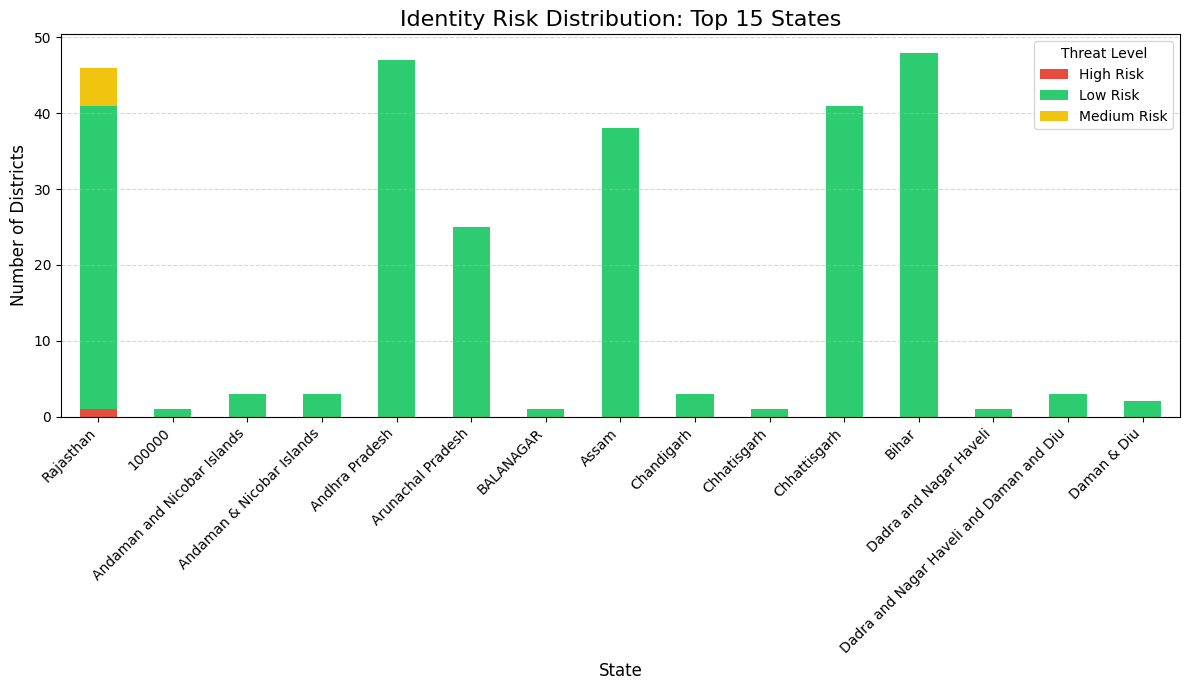

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data: Count of Risk Levels per State
risk_counts = master_df.groupby(['state', 'risk_level']).size().unstack(fill_value=0)

# Sort by High Risk count to make the chart look structured
risk_counts = risk_counts.sort_values(by='High Risk', ascending=False).head(15)

# Plotting
plt.figure(figsize=(12, 7))
risk_counts.plot(kind='bar', stacked=True, 
                 color={'Low Risk': '#2ecc71', 'Medium Risk': '#f1c40f', 'High Risk': '#e74c3c'},
                 ax=plt.gca())

plt.title('Identity Risk Distribution: Top 15 States', fontsize=16)
plt.ylabel('Number of Districts', fontsize=12)
plt.xlabel('State', fontsize=12)
plt.legend(title='Threat Level')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [35]:
# Comparison of averages
forensics = master_df.groupby('risk_level')[['demo_update_rate', 'bio_update_rate', 'imbalance_score']].mean()

print("\n--- FORENSIC PROFILE PER RISK LEVEL ---")
print(forensics)


--- FORENSIC PROFILE PER RISK LEVEL ---
             demo_update_rate  bio_update_rate  imbalance_score
risk_level                                                     
High Risk         1057.000000        15.000000         0.999068
Low Risk            10.081926        14.351106         0.802902
Medium Risk        275.369048         3.313492         0.993967


In [36]:
stability_index = (1 - (master_df['imbalance_score'].abs().mean())) * 100
print(f"\nGLOBAL IDENTITY STABILITY INDEX: {stability_index:.2f}%")


GLOBAL IDENTITY STABILITY INDEX: 12.77%


In [37]:
# 🔍 What is killing our stability?
demo_weight = master_df['Demographic Total'].sum()
bio_weight = master_df['Biometric Total'].sum()
enrol_weight = master_df['Enrolment Total'].sum()

print(f"--- THE INSTABILITY DRIVERS ---")
print(f"Total Enrolments: {enrol_weight}")
print(f"Total Demo Updates: {demo_weight} ({demo_weight/enrol_weight:.1f}x Enrolments)")
print(f"Total Bio Updates: {bio_weight} ({bio_weight/enrol_weight:.1f}x Enrolments)")

--- THE INSTABILITY DRIVERS ---
Total Enrolments: 5435702.0
Total Demo Updates: 49295187.0 (9.1x Enrolments)
Total Bio Updates: 69763095.0 (12.8x Enrolments)


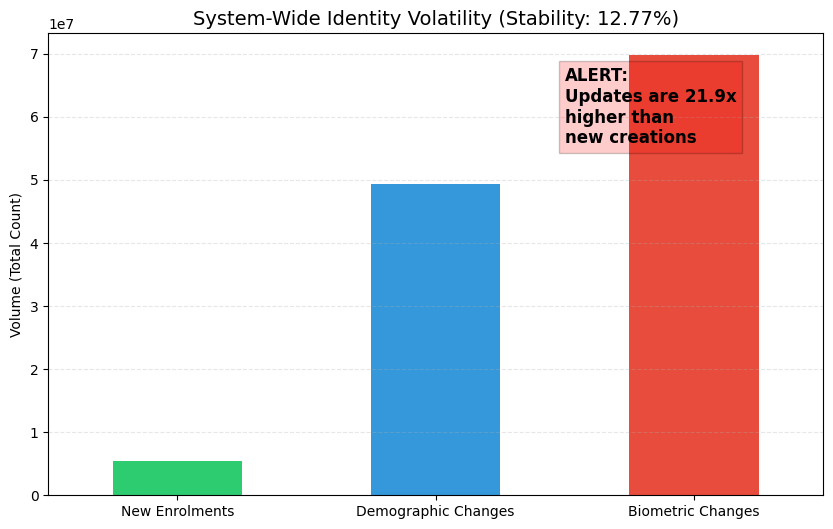

In [38]:
import matplotlib.pyplot as plt

# Comparison of Totals
totals = pd.Series({
    'New Enrolments': enrol_weight,
    'Demographic Changes': demo_weight,
    'Biometric Changes': bio_weight
})

plt.figure(figsize=(10, 6))
colors = ['#2ecc71', '#3498db', '#e74c3c']
totals.plot(kind='bar', color=colors)

plt.title(f'System-Wide Identity Volatility (Stability: {stability_index:.2f}%)', fontsize=14)
plt.ylabel('Volume (Total Count)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add a text box explaining the 12.7%
plt.text(1.5, totals.max()*0.8, f"ALERT:\nUpdates are { (demo_weight+bio_weight)/enrol_weight :.1f}x\nhigher than\nnew creations", 
         bbox=dict(facecolor='red', alpha=0.2), fontsize=12, fontweight='bold')

plt.show()

In [39]:
# Create a forensic report of all anomalies
forensic_report = master_df[master_df['risk_level'] != 'Low Risk'].sort_values('composite_risk_index', ascending=False)

# Add a "Reason" column for the report
forensic_report['Primary Risk'] = np.where(
    forensic_report['demo_update_rate'] > forensic_report['bio_update_rate'], 
    "Demographic Manipulation", "Biometric Volatility"
)

# Export to CSV
forensic_report.to_csv('aadhaar_forensic_audit_report.csv', index=False)
print(f"✅ Forensic Report exported! {len(forensic_report)} suspicious districts logged.")

✅ Forensic Report exported! 7 suspicious districts logged.
